In [1]:
!pip install spotipy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
pip install tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Import Libraries

In [3]:
import numpy as np
import pandas as pd

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from tqdm import tqdm  
import time

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

# DATA COLLECTION

In [4]:
# Set up API credentials
client_id = "3ff1e45f1c8d4189b317e02b3dc349b6" # Replace with your actual Client ID
client_secret = "878f0386a88f4c08b54199f30770c950"  # Replace with your actual Client Secret

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

### Spotify API

### Get Tracks

In [5]:
def top_tracks_by_year(start, end, n):
    results_by_year = {}

    for year in range(start, end+1):
        tracks = []
        ofs = 0

        while len(tracks) < n:
            rem_n = n - len(tracks)
            track_info = sp.search(q=f'year:{year}', type='track', market='US', limit=rem_n, offset=ofs)
            items = track_info['tracks']['items']

            for t in items:
                artists = t['artists'][0]['name']
                popularity = t['popularity']
                track_id = t['id'] 
                
                tracks.append({
                    'artists': artists,
                    'popularity': popularity,
                    'id': track_id
                })

            ofs += rem_n

        results_by_year[year] = tracks

    return results_by_year

# Change year and top n tracks here
top_tracks = top_tracks_by_year(1950, 2024, 50)

### Convert to DF

In [6]:
data = []

# Append tracks and their features to data
for year in top_tracks:
    tracks = top_tracks[year]

    for track in tracks:
        data.append({
            'Year': year,
            'Artist': track['artists'],
            'Popularity': track['popularity'],
            'Track ID': track['id'], # Use for removing identical entries
        })

# Create the DataFrame
df = pd.DataFrame(data)

### Create Genres

In [7]:
# Create a list to store genres
genres_list = []

# Loop through the DataFrame to get genres from artist info
for idx, row in tqdm(df.iterrows(), total=len(df)):
    try:
        artist_name = row['Artist']
        search_artist = sp.search(q=f"artist:{artist_name}", type='artist')
        artist_items = search_artist['artists']['items']
        
        if artist_items:
            artist_info = artist_items[0]
            genres = artist_info['genres']
            genres_list.append(genres[0] if genres else None)  # Pick the first genre if exists
        else:
            genres_list.append(None)
            
    except Exception as e:
        genres_list.append(None)

    time.sleep(0.05)  # Prevent hitting rate limit

# Add genre column to your DataFrame
df['Genre'] = genres_list

100%|██████████| 3750/3750 [10:51<00:00,  5.76it/s]


### DF to CSV Conversion

In [8]:
# Create csv file, move this down after adding genre to df
df.to_csv('spotify_top_tracks_with_genres.csv', index=False)

# DATA CLEANING AND PREPROCESSING

### Read CSV

In [9]:
# After completing Data Collection 
# Start here when updating DF
def read_data(file_name):
    df = pd.read_csv(file_name)
    return df

# Use this so we don't have to constantly fetch genre
data = read_data('spotify_top_tracks_with_genres.csv')

### DF Cleaning

In [10]:
# Remove any row that contains null value 
cleaned_df = data.dropna().reset_index(drop=True)

# Remove any duplicate song
# Then remove Track ID and Artist column, since there's no further use for it
cleaned_df = cleaned_df.drop_duplicates(subset='Track ID')
cleaned_df = cleaned_df.drop(['Track ID', 'Artist'], axis=1)

In [11]:
cleaned_df

,Year,Popularity,Genre
0,1950,59,vocal jazz
1,1950,55,vocal jazz
2,1950,47,doo-wop
3,1950,45,honky tonk
4,1950,46,mambo
...,...,...,...
2824,2024,83,country
2825,2024,88,egyptian pop
2826,2024,83,country
2827,2024,81,country


In [12]:
# Identify unique subgenres
cleaned_df['Genre'].unique()

array(['vocal jazz', 'doo-wop', 'honky tonk', 'mambo', 'jazz', 'bolero',
       'orchestra', 'cool jazz', 'soul', 'bluegrass', 'opm', 'mariachi',
       'hard bop', 'neoclassical', 'christmas', 'french jazz',
       'swing music', 'classical piano', 'adult standards',
       'boogie-woogie', 'exotica', 'bebop', 'opera', 'musicals',
       'big band', 'easy listening', 'folk', 'traditional country',
       'comedy', 'brazilian jazz', 'schlager', 'canzone napoletana',
       'ranchera', 'blues', 'christian country', 'rockabilly', 'calypso',
       'country', 'jazz blues', 'moroccan chaabi', 'classical',
       'bossa nova', 'new york drill', 'motown', 'rock and roll',
       'surf rock', 'nu disco', 'salsa', 'folk rock', 'chanson',
       'latin jazz', 'soul jazz', 'baroque pop', 'classic rock',
       'northern soul', 'progressive rock', 'proto-punk', 'mpb',
       'philly soul', 'cha cha cha', 'psychedelic rock', 'kizomba',
       'disco', 'acid rock', 'glam rock', 'southern rock', 'me

### Map Subgenre to Broad Genre

In [13]:
# Genre mapping dictionary
# Ultra-general genre mapping
genre_map = {
    'Jazz & Blues': [
        'vocal jazz', 'cool jazz', 'bebop', 'jazz blues', 'soul jazz', 'jazz',
        'blues', 'swing music', 'hard bop', 'big band', 'jazz funk', 'latin jazz',
        'brazilian jazz', 'exotica', 'boogie-woogie', 'free jazz'
    ],
    'Classical': [
        'classical', 'classical piano', 'japanese classical', 'orchestra',
        'opera', 'musicals', 'symphonic rock', 'neoclassical', 'baroque pop'
    ],
    'Rock & Alternative': [
        'rock', 'classic rock', 'hard rock', 'progressive rock', 'psychedelic rock',
        'album rock', 'southern rock', 'soft rock', 'alternative rock', 'glam rock',
        'punk', 'grunge', 'metal', 'glam metal', 'industrial rock', 'industrial metal',
        'garage rock', 'noise rock', 'stoner rock', 'post-punk', 'post-hardcore',
        'thrash metal', 'progressive metal', 'folk punk', 'shoegaze', 'britpop',
        'dream pop', 'jangle pop', 'post-grunge'
    ],
    'Pop & Electronic': [
        'pop', 'soft pop', 'synthpop', 'power pop', 'art pop', 'dance pop',
        'hyperpop', 'chamber pop', 'bedroom pop', 'variété française', 'city pop',
        'edm', 'eurodance', 'hi-nrg', 'french house', 'house', 'techno',
        'nu disco', 'moombahton', 'future bass', 'dancehall', 'electronica',
        'italo disco'
    ],
    'Hip Hop & R&B': [
        'hip hop', 'rap', 'jazz rap', 'melodic rap', 'emo rap', 'rage rap',
        'drill', 'new york drill', 'dark trap', 'crunk', 'g-funk', 'trap',
        'gangster rap', 'horrorcore', 'experimental hip hop', 'hip house',
        'r&b', 'soul', 'neo soul', 'motown', 'quiet storm', 'funk', 'funk rock',
        'new jack swing', 'disco', 'gospel', 'philly soul', 'alternative r&b'
    ],
    'Country, Folk & World': [
        'country', 'alt country', 'traditional country', 'folk', 'folk pop',
        'folk rock', 'honky tonk', 'bluegrass', 'americana', 'red dirt',
        'country rock', 'ranchera', 'norteño', 'banda', 'corrido', 'reggaeton',
        'salsa', 'tejano', 'latin pop', 'mambo', 'bolero', 'mariachi', 'grupera',
        'calypso', 'kizomba', 'merengue', 'bachata', 'cumbia', 'mpb', 'latin alternative'
    ],
}

# Flatten and apply
flat_genre_map = {sub: broad for broad, subs in genre_map.items() for sub in subs}
cleaned_df['Broad Genre'] = cleaned_df['Genre'].map(flat_genre_map).fillna('Other / Misc')

### Count of Each Broad Genre by Half-Decade 
### Remove 'Genre' Column

In [14]:
# Half Decade
cleaned_df['Semi-Decade'] = (cleaned_df['Year'] // 5) * 5

# Groupby Year and Broad Genre
genre_counts_year = cleaned_df.groupby(['Year', 'Broad Genre']).size().unstack(fill_value=0)

# Groupby Semi-Decade and Broad Genre
genre_counts_sd = cleaned_df.groupby(['Semi-Decade', 'Broad Genre']).size().unstack(fill_value=0)

# KMeans Clustering

Text(0, 0.5, 'WCSS')

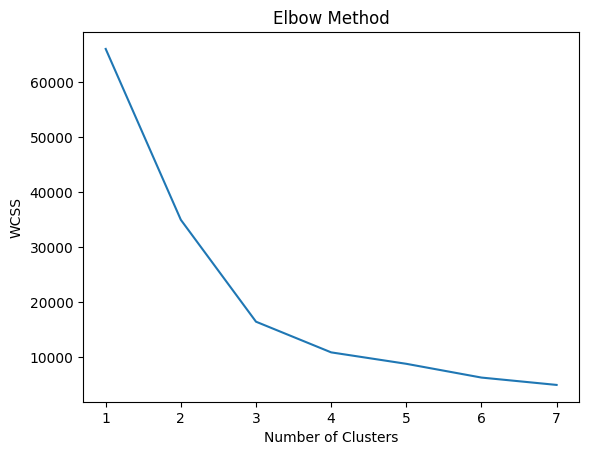

In [15]:
# Using Elbow to determine number of clusters we should for KMeans Clustering
wcss = []
    
for i in range(1,8):
    kmeans = KMeans(i)
    kmeans.fit(genre_counts_sd)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,8)
plt.plot(number_clusters, wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

##### Based on the graph above the optimal number of clusters we should use for KMeans Clustering is 3.

In [16]:
def kmeans_clustering(data):

    kmeans = KMeans(3)
    data['KMeans_Cluster'] = kmeans.fit_predict(data)

    return data

clustered_data = kmeans_clustering(genre_counts_sd)
clustered_data

Broad Genre,Classical,"Country, Folk & World",Hip Hop & R&B,Jazz & Blues,Other / Misc,Pop & Electronic,Rock & Alternative,KMeans_Cluster
Semi-Decade,,,,,,,,
1950,14,70,1,91,56,0,0,2
1955,3,24,2,104,98,0,0,2
1960,7,33,31,44,91,1,15,2
1965,11,36,43,5,26,0,89,0
1970,1,43,22,3,17,2,114,0
1975,10,19,25,3,27,5,131,0
1980,3,24,19,1,43,12,100,0
1985,4,34,14,1,52,7,84,0
1990,0,46,24,0,31,7,94,0


# Hierarchical Clustering

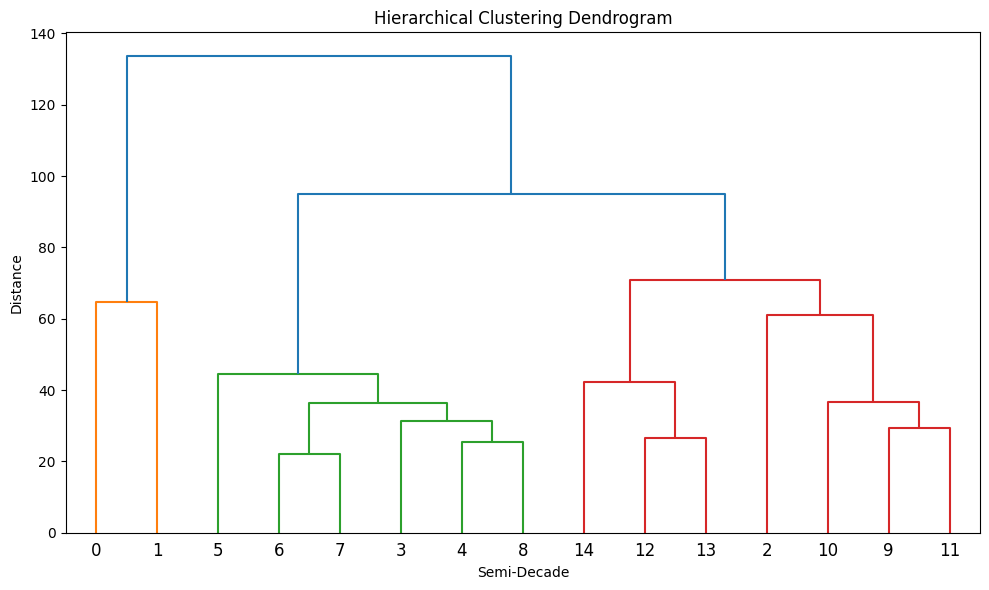

In [17]:
# Dendrogram visualization 
# Average linkage method
Z = linkage(genre_counts_sd, method='average')  

# Plot
plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Semi-Decade')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

##### Based on the graph above the optimal number of clusters we should use for Hierarchical Clustering is 4.

In [18]:
def hierarchical_clustering(data):
    
    hc = AgglomerativeClustering(3)
    data['Hierarchical_Cluster'] = hc.fit_predict(data)

hierarchical_clustering(genre_counts_sd)
clustered_data

Broad Genre,Classical,"Country, Folk & World",Hip Hop & R&B,Jazz & Blues,Other / Misc,Pop & Electronic,Rock & Alternative,KMeans_Cluster,Hierarchical_Cluster
Semi-Decade,,,,,,,,,
1950,14,70,1,91,56,0,0,2,2
1955,3,24,2,104,98,0,0,2,2
1960,7,33,31,44,91,1,15,2,0
1965,11,36,43,5,26,0,89,0,1
1970,1,43,22,3,17,2,114,0,1
1975,10,19,25,3,27,5,131,0,1
1980,3,24,19,1,43,12,100,0,1
1985,4,34,14,1,52,7,84,0,1
1990,0,46,24,0,31,7,94,0,1


# DATA VISUALIZATION

### Process Data

In [19]:
# Process data so that it can be visualized
pca = PCA(2)

vis_data = pd.DataFrame(pca.fit_transform(clustered_data), columns=['PCA1', 'PCA2'])

vis_data['KMeans_Cluster'] = clustered_data['KMeans_Cluster'].values
vis_data['Hierarchical_Cluster'] = clustered_data['Hierarchical_Cluster'].values

### Visualize Clusters

In [ ]:
# KMeans
plt.figure(figsize = (10,8))
sns.scatterplot(data=vis_data, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='Set1') 
plt.title("Visualization of KMeans Clustering")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.tight_layout()
plt.show()

# Hierarchical
plt.figure(figsize = (10,8))
sns.scatterplot(data=vis_data, x='PCA1', y='PCA2', hue='Hierarchical_Cluster', palette='Set2')
plt.title("Visualization of Hierarchical Clustering")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.tight_layout()
plt.show()

### Line Plot of Genre Count Over Time (By Year)

In [ ]:
genre_counts_year.plot(figsize=(12,6), marker='.')
plt.title("Genre Count Over Time (Year)")
plt.xlabel("Year")
plt.ylabel("Count of Tracks")
plt.legend(title="Genre")
plt.tight_layout()
plt.show()

### Line Plot of Genre Count Over Time (By Semi-Decade)

In [ ]:
genre_counts_sd.plot(figsize=(12,6), marker='.')
plt.title("Genre Count Over Time (Semi-Decade)")
plt.xlabel("Semi-Decade")
plt.ylabel("Count of Tracks")
plt.legend(title="Genre")
plt.tight_layout()
plt.show()

### Heatmap Visualization

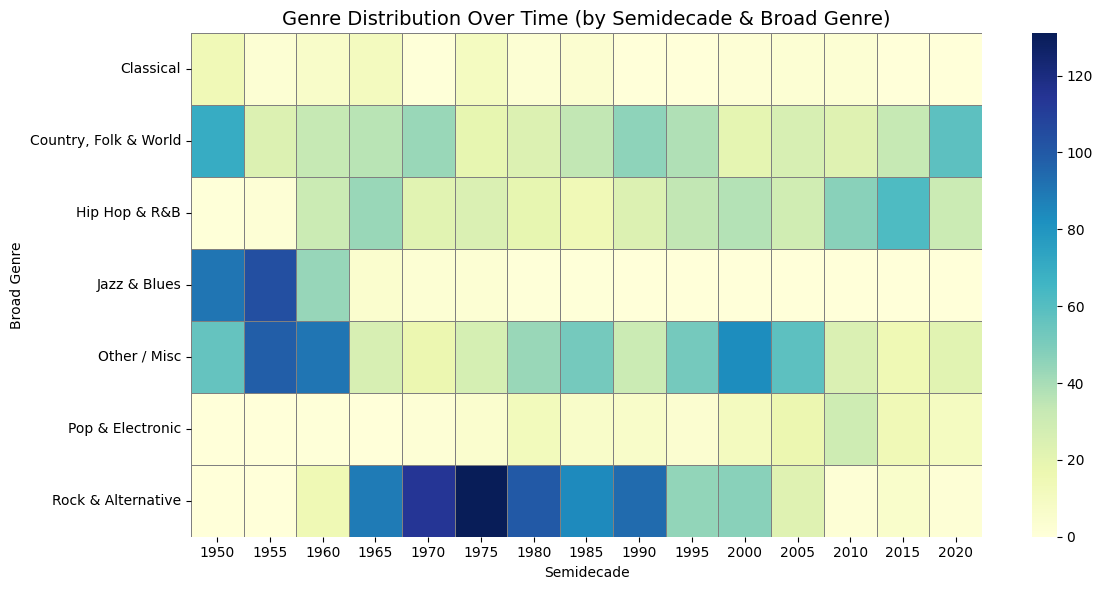

In [23]:
# Pivot table for Broad Genre vs Decade
genre_heatmap_sd = cleaned_df.pivot_table(
    index='Broad Genre',
    columns='Semi-Decade',
    values='Popularity',
    aggfunc='count',
    fill_value=0
)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(genre_heatmap_sd, cmap='YlGnBu', linewidths=0.5, linecolor='gray')
plt.title('Genre Distribution Over Time (by Semidecade & Broad Genre)', fontsize=14)
plt.xlabel('Semidecade')
plt.ylabel('Broad Genre')
plt.tight_layout()
plt.show()

# Evaluate Quality and Accuracy of Clustering

### Distance Matrix of Data Points

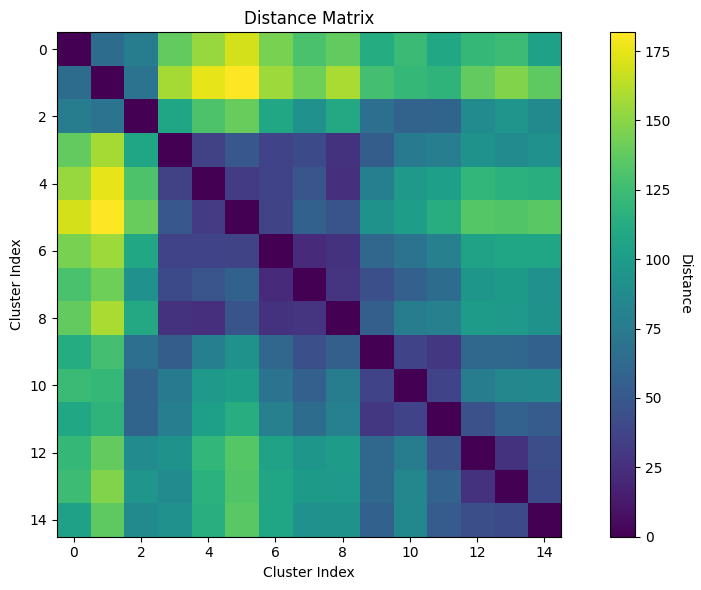

In [24]:
# Distance Matrix Visualization
distance_matrix = squareform(pdist(genre_counts_sd))

fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.matshow(distance_matrix, cmap='viridis')
ax.xaxis.set_ticks_position('bottom')

cbar = fig.colorbar(cax)
cbar.ax.set_ylabel('Distance', rotation=270, labelpad=15)

plt.title('Distance Matrix')
plt.xlabel('Cluster Index')
plt.ylabel('Cluster Index')
plt.tight_layout()
plt.show()

### Location of Data Points in the CLusters

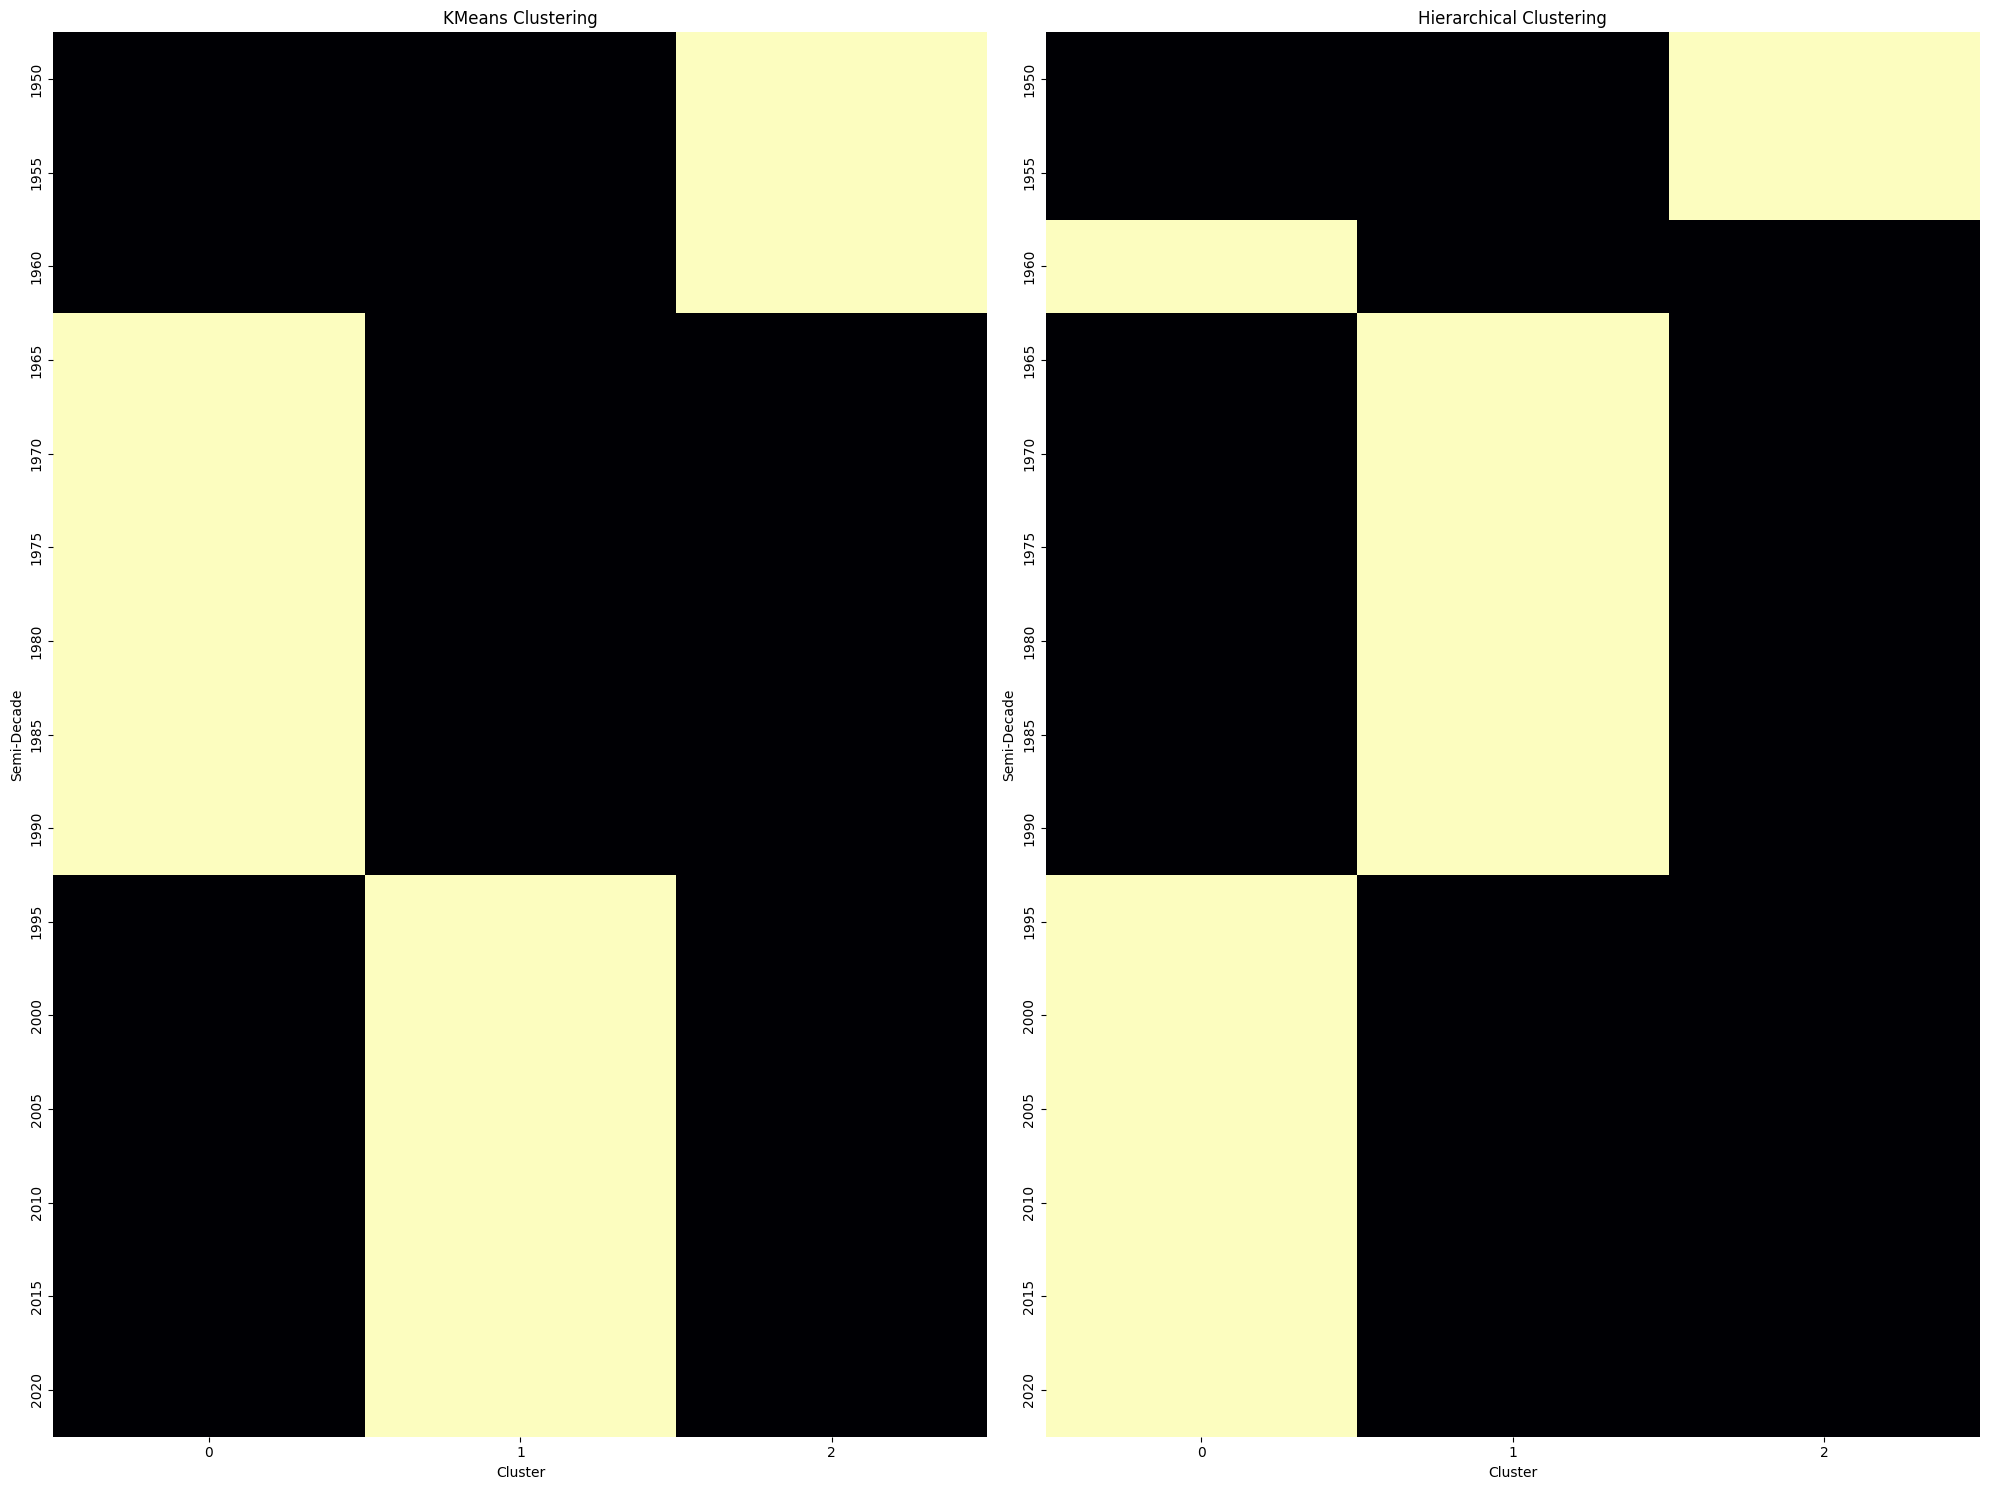

In [25]:
heat_kmeans = clustered_data.groupby(['Semi-Decade', 'KMeans_Cluster']).size().unstack(fill_value=0)
heat_hc = clustered_data.groupby(['Semi-Decade', 'Hierarchical_Cluster']).size().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(20, 15)) 

# KMeans Clustering Heatmap
sns.heatmap(heat_kmeans, cmap="magma", cbar=False, ax=axes[0])
axes[0].set_title("KMeans Clustering")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Semi-Decade")

# Hierarchical Clustering Heatmap
sns.heatmap(heat_hc, cmap="magma", cbar=False, ax=axes[1])
axes[1].set_title("Hierarchical Clustering")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Semi-Decade")

plt.tight_layout()
plt.show()